# 0. Import Dependencies

In [2]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

# 1. Prepare Dataset

In [3]:
class CardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index]
    @property
    def classes(self):
        return self.data.classes

* Training Set

19

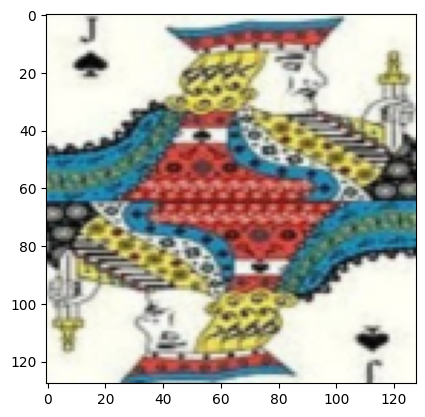

In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])
train_set = CardDataset('dataset/train', transform)
tr_image, tr_label = train_set[3000]
tr_image = tr_image / 2 + 0.5
plt.imshow(transforms.ToPILImage()(tr_image))
tr_label

* Validation Set

6

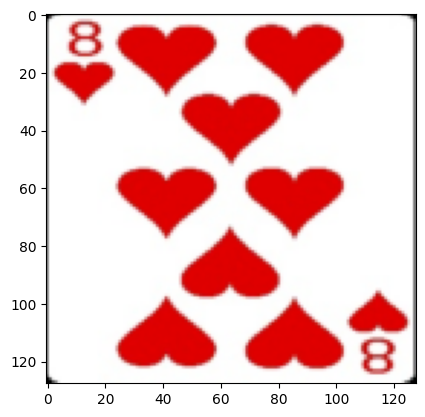

In [5]:
val_set = CardDataset('dataset/valid', transform)
v_image, v_label = val_set[30]
v_image = v_image / 2 + .5
plt.imshow(transforms.ToPILImage()(v_image))
v_label

* Test Set

6

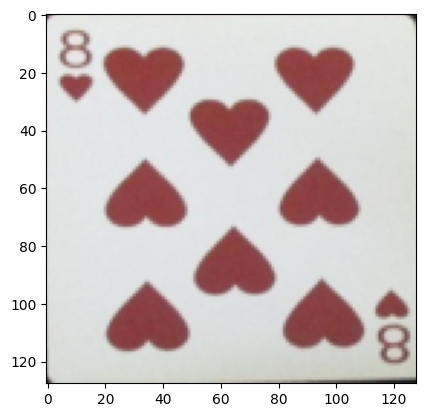

In [6]:
test_set = CardDataset('dataset/test', transform)
te_image, te_label = test_set[30]
te_image = te_image / 2 + .5
plt.imshow(transforms.ToPILImage()(te_image))
te_label

# 2. Data Loader

In [7]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

images, labels = next(iter(train_loader))
print(images.size())
print(labels.size())

torch.Size([16, 3, 128, 128])
torch.Size([16])


# 3. Build Model

In [41]:
class CradClassifier(nn.Module):
    def __init__(self):
        super(CradClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 8, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(16 * 30 * 30, 512),
            nn.Linear(512, 128),
            nn.Linear(128, 53)
        )

    def forward(self, x):
        x = self.model(x)
        return x

model = CradClassifier()
model

CradClassifier(
  (model): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=14400, out_features=512, bias=True)
    (8): Linear(in_features=512, out_features=128, bias=True)
    (9): Linear(in_features=128, out_features=53, bias=True)
  )
)

In [42]:
output = model(images)
output.shape

torch.Size([16, 53])

In [43]:
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-6)
criterion = nn.CrossEntropyLoss()

# 4. Training Loop

In [44]:
EPOCHS = 20
train_losses, val_losses = [], []
accs = []

for epoch in range(EPOCHS):
    running_loss = correct = total = 0
    model.train()
    for b, data in enumerate(train_loader, 0):
        X, y = data
        optimizer.zero_grad()
        yhat = model(X)
        loss = criterion(yhat, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    t_loss = running_loss / len(train_loader)
    train_losses.append(t_loss)
    print(f'{epoch + 1})- Train:')
    print(t_loss)

    model.eval()
    running_loss = 0
    with torch.no_grad():
        for b, data in enumerate(val_loader):
            X, y = data
            yhat = model(X)
            _, pred = torch.max(yhat.data, 1)
            loss = criterion(yhat, y)
            running_loss += loss.item()
            total += y.size(0)
            correct += (pred == y).sum().item()
    v_loss = running_loss / len(val_loader)
    val_losses.append(v_loss)
    acc = correct / total
    accs.append(acc)
    print(f'{epoch + 1})- Validation:')
    print(f'Loss: {v_loss}')
    print(f'Accuracy: {100 * acc}')
    print('~' * 50)

1)- Train:
2.437914213669375
1)- Validation:
Loss: 1.4532984284793629
Accuracy: 61.50943396226415
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2)- Train:
1.2160181320063472
2)- Validation:
Loss: 1.0673491621718687
Accuracy: 71.32075471698113
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
3)- Train:
0.5213054128662845
3)- Validation:
Loss: 1.026693938409581
Accuracy: 73.58490566037736
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
4)- Train:
0.27704680744125126
4)- Validation:
Loss: 1.2263779535013086
Accuracy: 73.9622641509434
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
5)- Train:
0.1994498704342402
5)- Validation:
Loss: 1.3824099319822647
Accuracy: 78.49056603773586
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
6)- Train:
0.1707503181602513
6)- Validation:
Loss: 1.1263598642476342
Accuracy: 78.49056603773586
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
7)- Train:
0.13950049737224304
7)- Validation:
Loss: 1.3325515950427336
Accuracy: 76.22641509433963
~~

# 5. Visualize Result

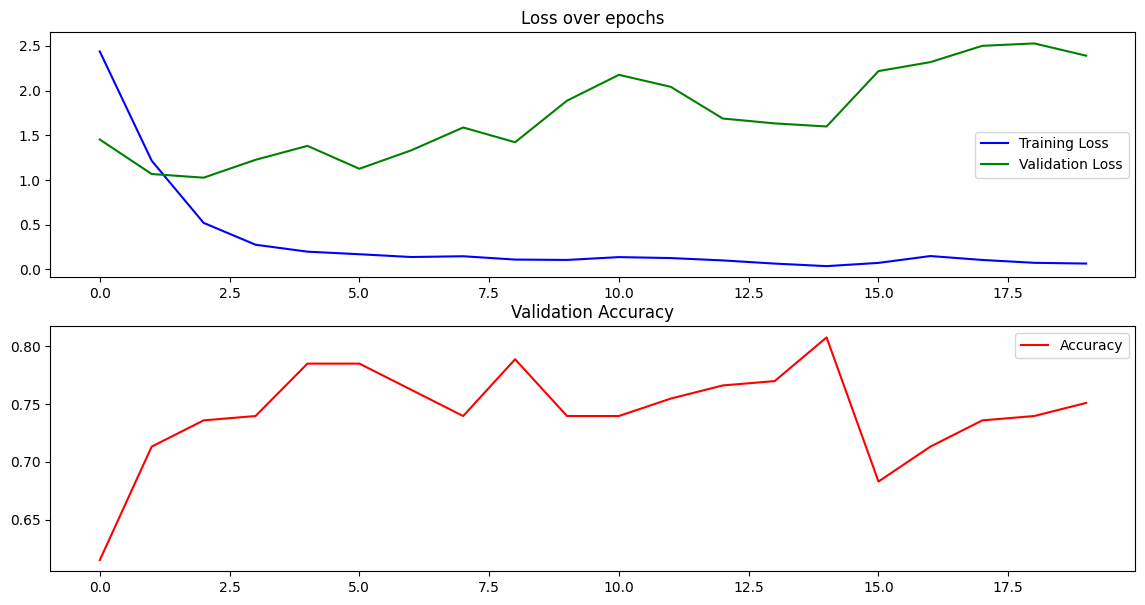

In [45]:
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(train_losses, 'b', label='Training Loss')
plt.plot(val_losses, 'g', label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(accs, 'r', label='Accuracy')
plt.title('Validation Accuracy')
plt.legend()

# 6. Test

In [67]:
import os

cards = os.listdir('dataset/test')

def testing(images, labels):
    fig, axes = plt.subplots(4, 4, figsize=(14, 7))
    correct = 0
    for i in range(len(images)):
        test_X, test_y = images[i], labels[i]
        test_yhat = model(torch.Tensor.expand(test_X, (1, 3, 128, 128)))
        _, prediction = torch.max(test_yhat.data, 1)
        correct += (prediction == test_y).sum().item()
        test_X = test_X / 2 + .5
        test_yhat = test_yhat.detach().numpy()

        fig.suptitle(f'Accuracy: {100 * correct / len(images)}')
        if i % 4 == 0:
            axes[i // 4, 0].set_title(cards[prediction.item()])
            axes[i // 4, 0].imshow(transforms.ToPILImage()(test_X))
        elif i % 4 == 1:
            axes[i // 4, 1].set_title(cards[prediction.item()])
            axes[i // 4, 1].imshow(transforms.ToPILImage()(test_X))
        elif i % 4 == 2:
            axes[i // 4, 2].set_title(cards[prediction.item()])
            axes[i // 4, 2].imshow(transforms.ToPILImage()(test_X))
        elif i % 4 == 3:
            axes[i // 4, 3].set_title(cards[prediction.item()])
            axes[i // 4, 3].imshow(transforms.ToPILImage()(test_X)) 

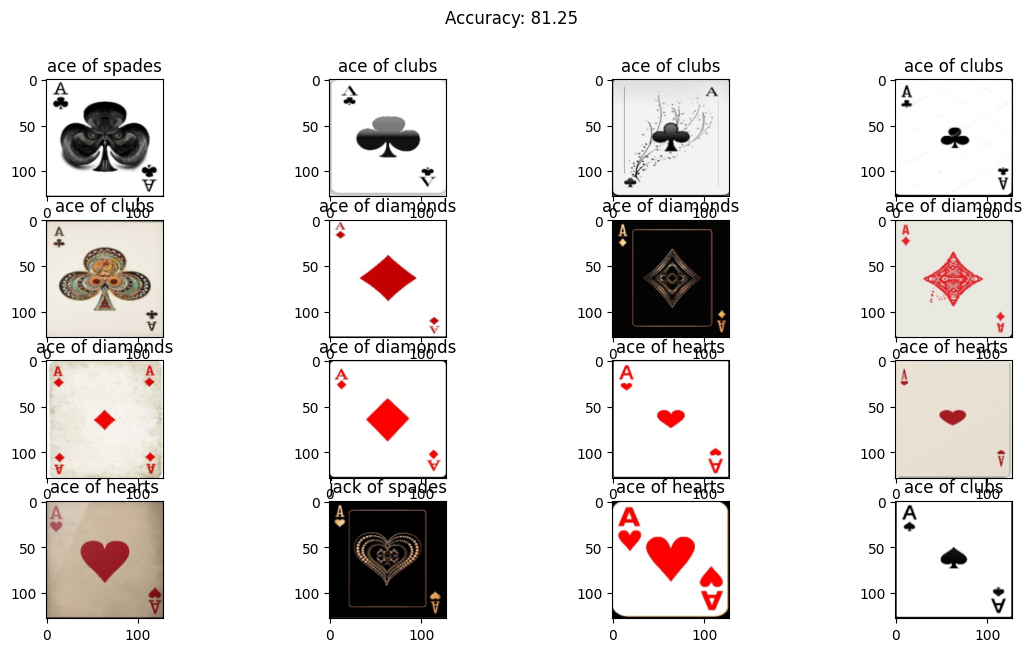

In [68]:
images, labels = next(iter(test_loader))
testing(images, labels)

* Test another batch

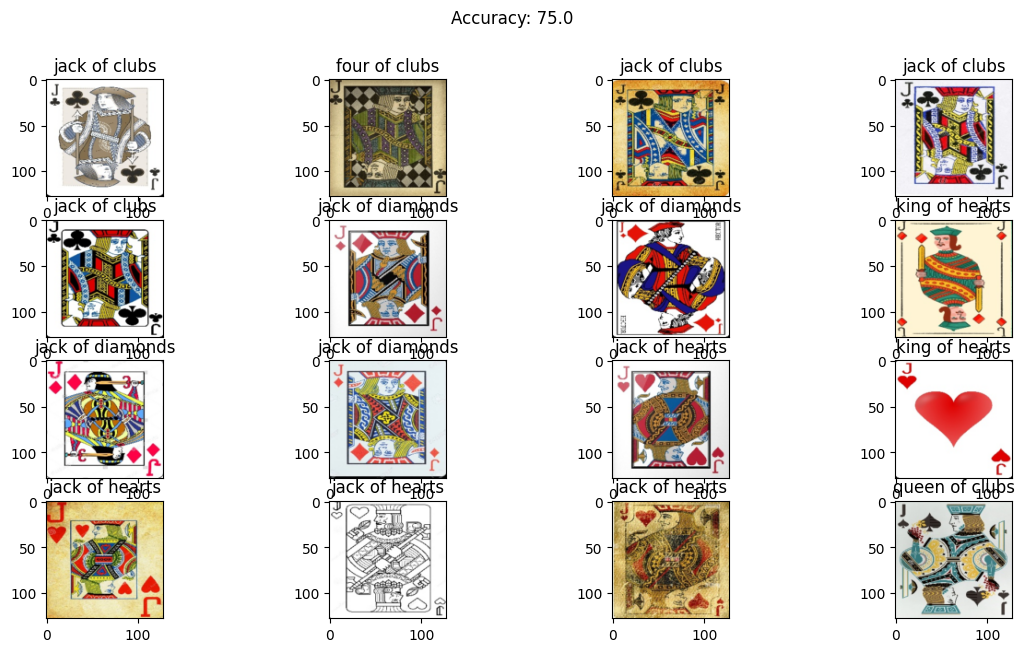

In [69]:
for i, batch in enumerate(test_loader):
    if i == 5:
        images, labels = batch

testing(images, labels)

In [ ]:
torch.save(model.state_dict(), 'model.pt')